In [ ]:
!pip install sentence-transformers faiss-cpu scikit-learn matplotlib

In [6]:
from sentence_transformers import SentenceTransformer
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import faiss

In [7]:
model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')
texts = [
    "The cat sat on the mat.",
    "A feline was resting on the rug.",
    "Dogs are playing in the park.",
    "She enjoys long walks by the river.",
    "He loves cooking Italian food.",
    "Automobiles have four wheels.",
    "Cars drive faster than bicycles.",
    "I’m reading a science fiction novel."
]

In [8]:

embeddings = model.encode(texts, convert_to_numpy=True, normalize_embeddings=True)
cosine_sim = embeddings @ embeddings.T  # since embeddings are normalized
print("Cosine similarity matrix:\n", np.round(cosine_sim, 2))

Cosine similarity matrix:
 [[ 1.    0.56  0.01  0.03  0.04 -0.01 -0.   -0.02]
 [ 0.56  1.    0.1   0.06  0.03  0.01 -0.07  0.02]
 [ 0.01  0.1   1.    0.05 -0.08  0.06  0.06  0.03]
 [ 0.03  0.06  0.05  1.    0.04  0.03  0.15  0.04]
 [ 0.04  0.03 -0.08  0.04  1.   -0.04  0.07  0.09]
 [-0.01  0.01  0.06  0.03 -0.04  1.    0.48  0.02]
 [-0.   -0.07  0.06  0.15  0.07  0.48  1.    0.15]
 [-0.02  0.02  0.03  0.04  0.09  0.02  0.15  1.  ]]


In [9]:
def plot_2d(X, title):
    plt.figure(figsize=(6,5))
    plt.scatter(X[:,0], X[:,1])
    for i, txt in enumerate(texts):
        plt.annotate(f"{i}", (X[i,0], X[i,1]))
    plt.title(title)
    plt.tight_layout()

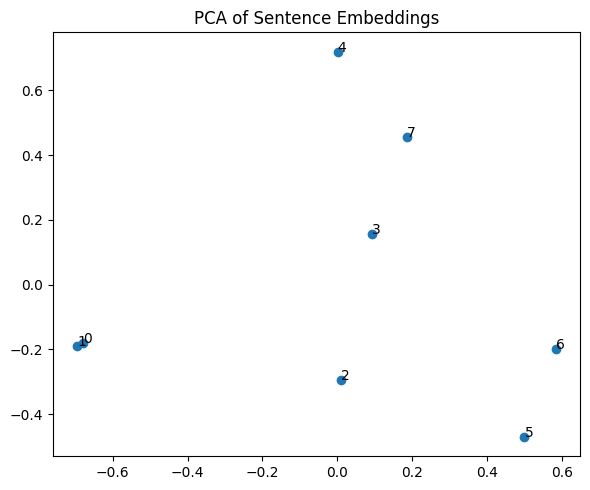

In [10]:
# PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(embeddings)
plot_2d(X_pca, "PCA of Sentence Embeddings")

/usr/local/Caskroom/miniconda/base/lib/python3.12/site-packages/threadpoolctl.py:1226: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


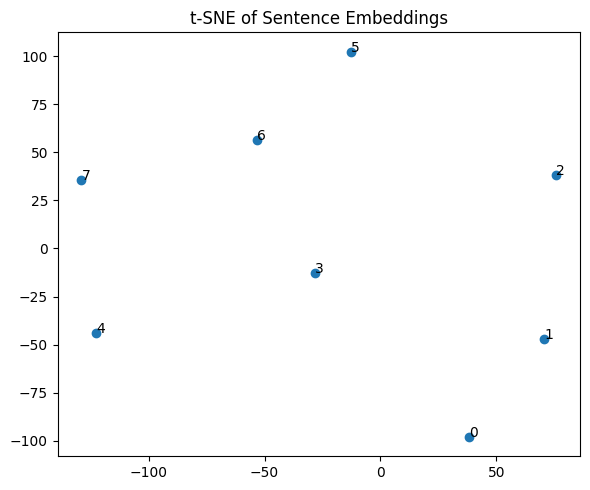

In [11]:
# t-SNE
tsne = TSNE(n_components=2, init='random', random_state=42,perplexity=5)
X_tsne = tsne.fit_transform(embeddings)
plot_2d(X_tsne, "t-SNE of Sentence Embeddings")
plt.show()

In [12]:

dim = embeddings.shape[1]
index = faiss.IndexFlatIP(dim)         
index.add(embeddings)                 


In [ ]:
queries = [
    "A cat is lying on the rug.",
    "An automobile moves quicker than a bike."
]
q_emb = model.encode(queries, convert_to_numpy=True, normalize_embeddings=True)

k = 3
D, I = index.search(q_emb, k)  # distances and indices

for qi, query in enumerate(queries):
    print(f"\nQuery: “{query}”")
    for rank, (idx, score) in enumerate(zip(I[qi], D[qi]), start=1):
        print(f"  {rank}. [{score:.3f}] {texts[idx]}")



## Observations

The top‐3 results show that embeddings don’t just match words—they capture meaning. You get exact synonyms first, then close paraphrases, and totally unrelated sentences score near zero.

- **Synonym magic:**  
  “A feline was resting on the rug” tops because “feline” ≈ “cat.”

- **Paraphrase power:**  
  “The cat sat on the mat” ranks second since “mat” and “rug” are similar and “sat” vs. “lying” is a small tweak.

- **Irrelevance filter:**  
  “He loves cooking Italian food” scores virtually zero, so it’s last.

- **Speed vs. specs:**  
  For the car query, “Cars drive faster than bicycles” wins—same idea, same words.  
  “Automobiles have four wheels” is next: still in the “vehicle” bucket even though it talks about parts, not speed.

- **Shared concepts:**  
  Both car results live close together in embedding space because they describe vehicles and motion, not just because they share words.
